In [ ]:
!pip install joblib imbalanced-learn
from google.colab import files
uploaded = files.upload()

Saving Text data (Sickle cell).xlsx to Text data (Sickle cell).xlsx


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_excel('Text data (Sickle cell).xlsx')
df.columns = df.columns.str.strip().str.replace(" ", "_").str.upper()
df.drop(columns=['S._NO.', 'AGE', 'SEX'], inplace=True, errors='ignore')

required_columns = ['RBC', 'PCV', 'MCV', 'MCH', 'MCHC', 'RDW', 'TLC', 'PLT_/MM3', 'HGB']
for col in required_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=required_columns, how='all', inplace=True)
df.fillna(df[required_columns].mean(), inplace=True)

# Rule-based label
def is_sickle_cell(row):
    return int(
        (row['HGB'] < 11) or
        (row['RDW'] > 15) or
        (row['MCV'] < 80) or
        (row['PLT_/MM3'] > 450)
    )
df['SICKLE_CELL'] = df.apply(is_sickle_cell, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[required_columns]
y = df['SICKLE_CELL']

# Train-test split with stratify to preserve imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

**Exploratory Data Analysis**


Summary Statistics:
               RBC          PCV          MCV          MCH         MCHC  \
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000   
mean      4.234217    36.315333    87.450508    28.249375    32.139608   
std       0.842315     6.963383     9.912361     4.015777     2.991294   
min       1.360000    13.100000    55.700000    14.700000    23.600000   
25%       3.700000    32.400000    82.300000    26.300000    30.300000   
50%       4.290000    36.200000    87.800000    28.200000    31.700000   
75%       4.790000    41.525000    92.100000    30.500000    33.400000   
max       6.900000    56.900000   124.100000    41.400000    50.200000   

               RDW          TLC     PLT_/MM3          HGB  SICKLE_CELL  
count  1200.000000  1200.000000  1200.000000  1200.000000  1200.000000  
mean     15.140375     8.600042   222.326167    11.774333     0.600000  
std       2.223326     4.455882   100.308477     2.190195     0.490102  
min      10.600000  

<ipython-input-9-ed1995177bbb>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SICKLE_CELL', data=df, palette='Set2')


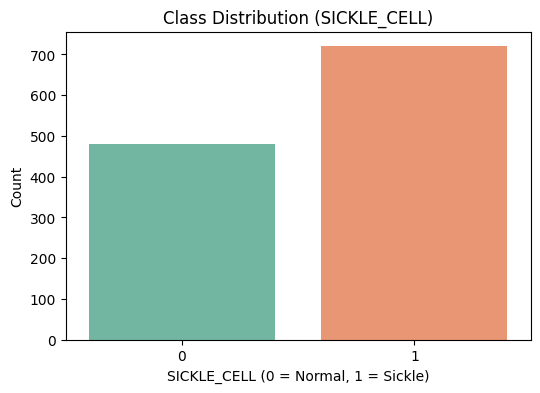

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Summary Statistics
print("\nSummary Statistics:")
print(df.describe())

# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='SICKLE_CELL', data=df, palette='Set2')
plt.title("Class Distribution (SICKLE_CELL)")
plt.xlabel("SICKLE_CELL (0 = Normal, 1 = Sickle)")
plt.ylabel("Count")
plt.show()


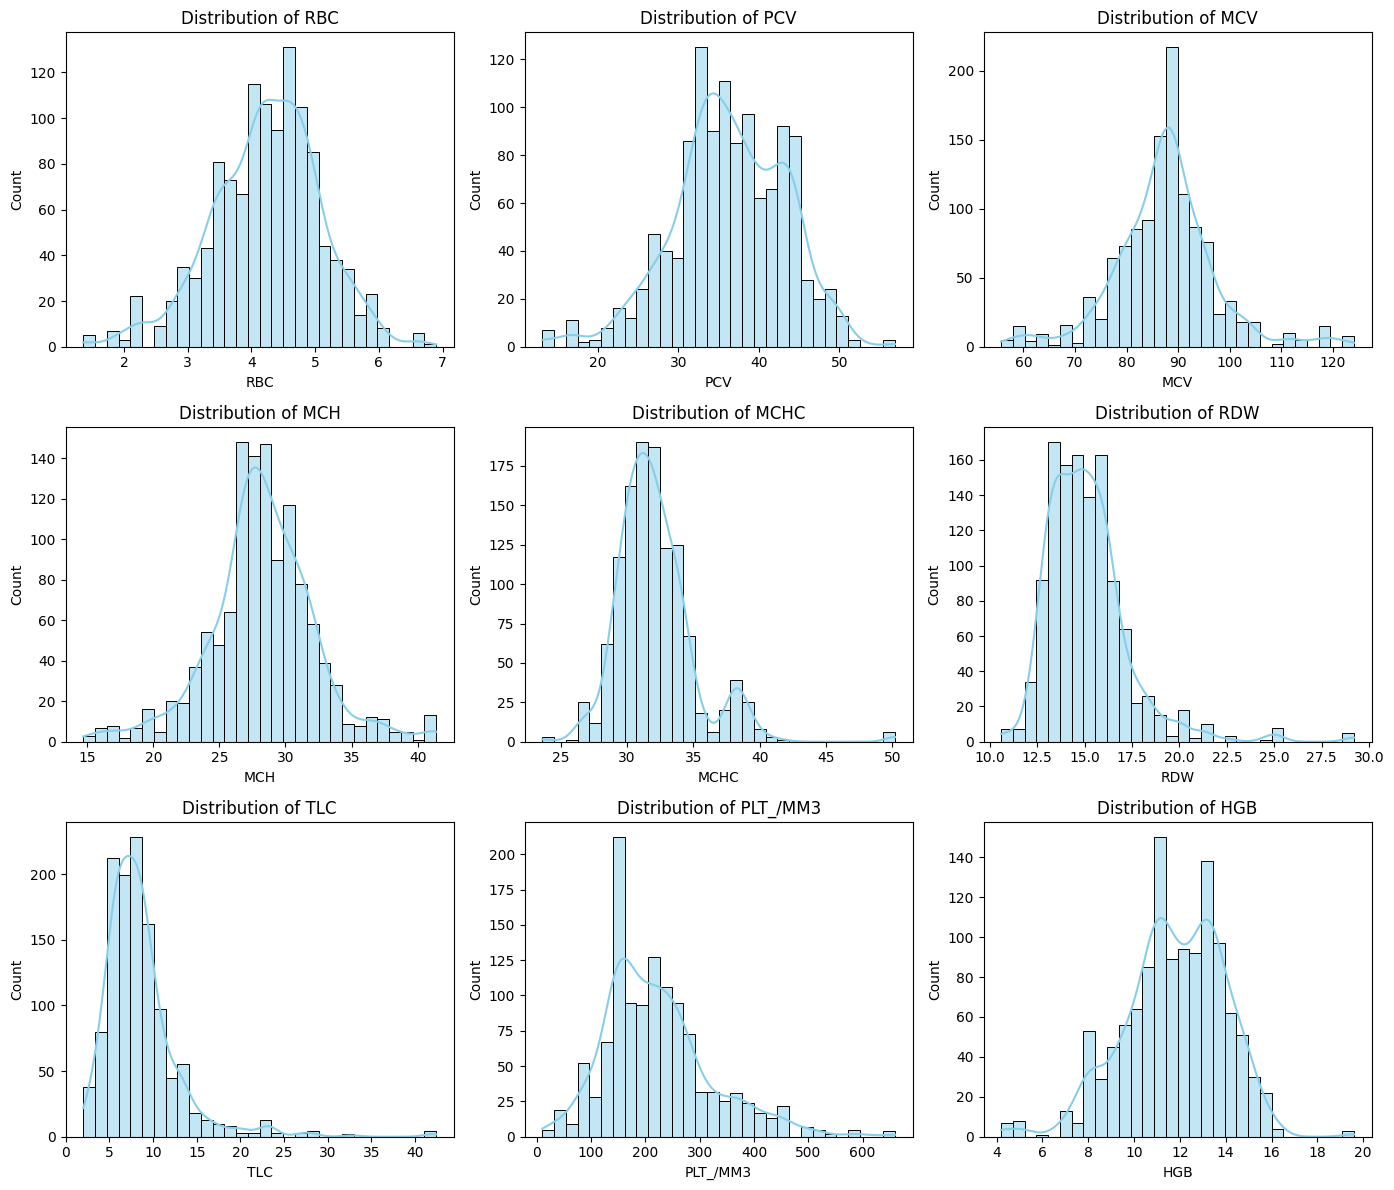

In [ ]:
# Distribution Plots for Each Feature
plt.figure(figsize=(14, 12))
for i, col in enumerate(required_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


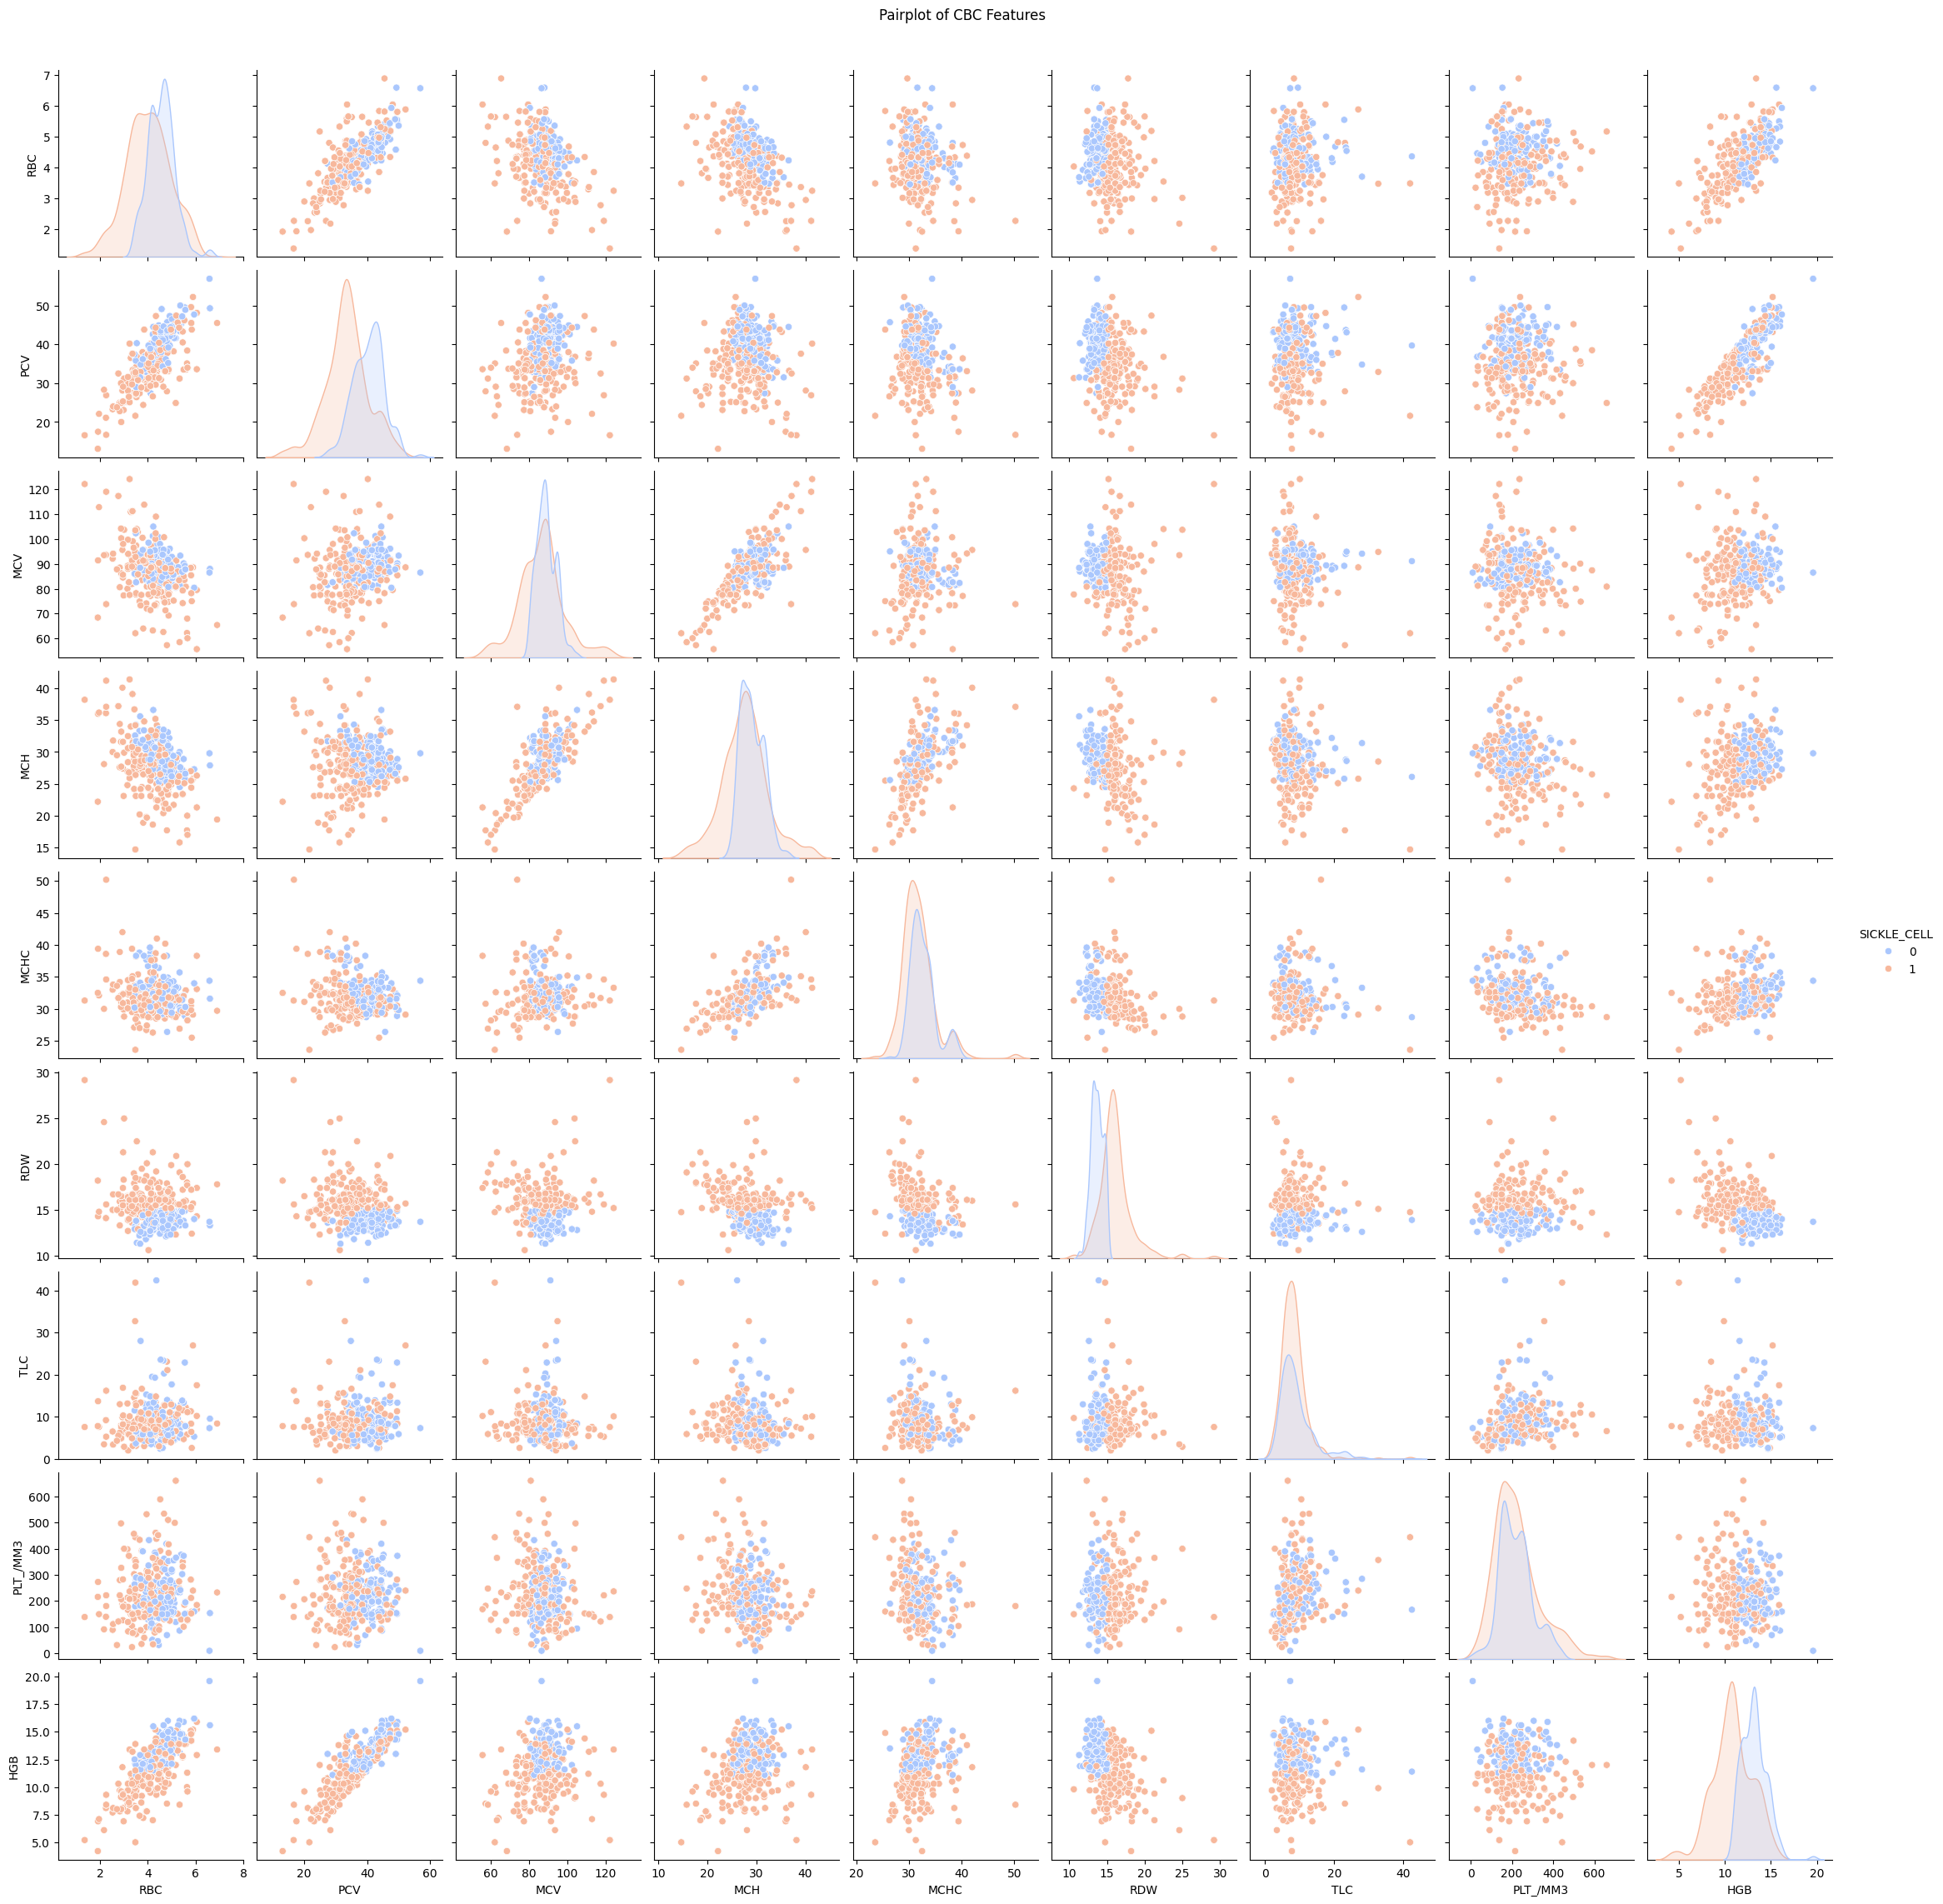

In [ ]:
# 5. Pairplot to Explore Feature Relationships
sns.pairplot(df, vars=required_columns, hue='SICKLE_CELL', diag_kind='kde', palette='coolwarm')
plt.suptitle("Pairplot of CBC Features", y=1.02)
plt.show()


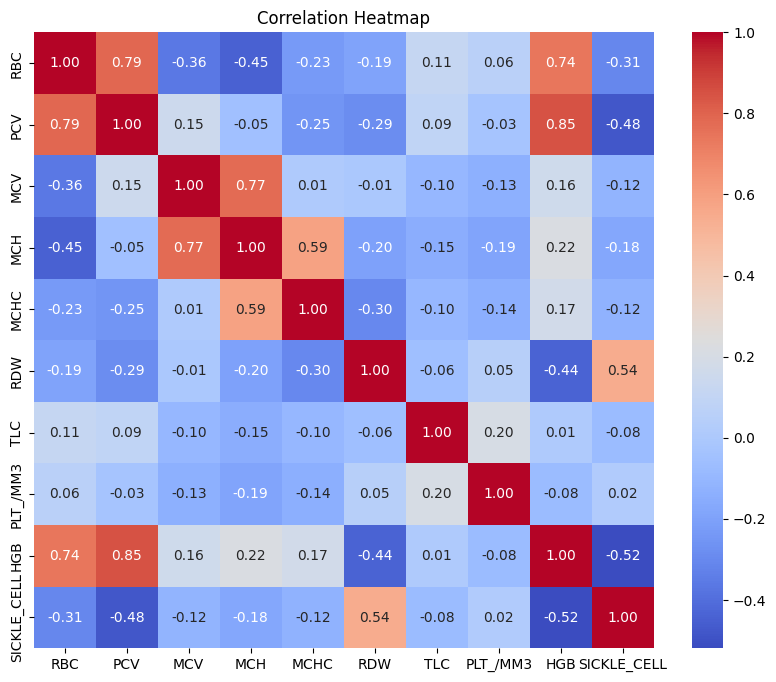

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df[required_columns + ['SICKLE_CELL']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Applied SMOTE for balanced class distribution**

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Check new class distribution
from collections import Counter
print("After SMOTE:", Counter(y_train_res))

After SMOTE: Counter({1: 576, 0: 576})


In [ ]:
joblib.dump(X_train_res, '/content/drive/MyDrive/X_train_res.pkl')
joblib.dump(y_train_res, '/content/drive/MyDrive/y_train_res.pkl')

['/content/drive/MyDrive/y_train_res.pkl']

<ipython-input-14-68a8330dc355>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette='viridis')


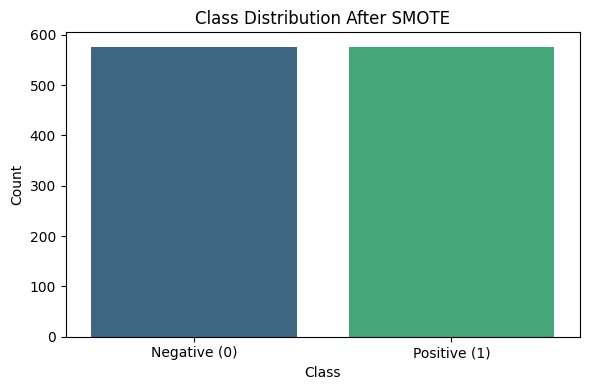

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_res, palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative (0)', 'Positive (1)'])
plt.tight_layout()
plt.show()


**Train SVM & generate Classification report on test data **

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm = SVC(probability=True)
svm.fit(X_train_res, y_train_res)

y_pred = svm.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

joblib.dump(svm, 'svm_model.pkl')


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        96
           1       1.00      0.94      0.97       144

    accuracy                           0.96       240
   macro avg       0.96      0.97      0.96       240
weighted avg       0.97      0.96      0.96       240

✅ Accuracy: 0.9625


['svm_model.pkl']

**Test on sample input**

In [ ]:
# Enter patient values manually here for prediction
user_input = {
    'RBC': 5.1,
    'PCV': 44,
    'MCV': 89,
    'MCH': 29.5,
    'MCHC': 34.2,
    'RDW': 12.6,
    'TLC': 6.9,
    'PLT_/MM3': 280,
    'HGB': 14.0
}


# Prediction function
def predict_user_data(user_input_dict):
    input_df = pd.DataFrame([user_input_dict])  # Convert to DataFrame with column names
    input_scaled = scaler.transform(input_df)   # Scale the input

    pred = svm.predict(input_scaled)[0]
    prob = svm.predict_proba(input_scaled)[0][1]

    print("\nPrediction:", "Sickle Cell Detected 🧬" if pred == 1 else "Normal")

# Run the prediction
predict_user_data(user_input)


Prediction: Normal


**Applied XAI->LIME**

In [ ]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e62c0be6d89daa11d57faf253d7bebbc73ccd78d2b46888764789ef4ef96824b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
explainer = LimeTabularExplainer(
    training_data=X_train_res,
    feature_names=required_columns,
    class_names=['Normal', 'Sickle Cell'],
    mode='classification'
)


In [ ]:
input_df = pd.DataFrame([user_input])
input_scaled = scaler.transform(input_df)

exp = explainer.explain_instance(
    data_row=input_scaled[0],
    predict_fn=svm.predict_proba,
    num_features=len(required_columns)
)

exp.show_in_notebook(show_table=True, show_all=False)

**Save model and scaler in Drive**

In [ ]:
drive_folder = "/content/drive/My Drive/SickleCellModels"
model = drive_folder + "/svm_model.pkl"
import os
import shutil
os.makedirs(drive_folder, exist_ok=True)

#Save models to Google Drive
shutil.copy('/content/svm_model.pkl', drive_folder + "/svm_model.pkl")

'/content/drive/My Drive/SickleCellModels/svm_model.pkl'

In [ ]:
local_scaler_path = '/content/scaler.pkl'
shutil.copy(local_scaler_path, os.path.join(drive_folder, 'scaler.pkl'))

'/content/drive/My Drive/SickleCellModels/scaler.pkl'

In [8]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c1bd14e219ade288552acbf470fdd397ed4c846194f8f0f670297ae0e4832fd9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [10]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s e

**COMBINED PREDICTION(Multimodal predictor)**

In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler
import joblib
import pickle
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Ensemble Prediction] -> Class: Sickle Cell
-> LIME Explanation (Text):


-> Grad-CAM Explanation (Image):


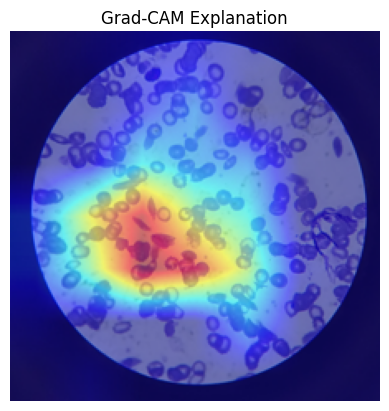

In [12]:
# ----- Globals -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
required_columns = ['RBC', 'PCV', 'MCV', 'MCH', 'MCHC', 'RDW', 'TLC', 'PLT_/MM3', 'HGB']

# ---------------------- IMAGE MODEL UTILS ----------------------
def get_transform(model_type):
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

def load_cnn_model(model_path):
    from torchvision.models import efficientnet_b0
    model = efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model_path):
    model = load_cnn_model(model_path)
    image = Image.open(image_path).convert("RGB")
    transform = get_transform("efficientnet")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[0]
        pred_label = np.argmax(probs)
    return probs, pred_label, model, input_tensor, image

def get_target_layer(model):
    return model.features[-1]

def explain_with_gradcam(model, input_tensor, image_pil):
    model = model.to("cpu")
    target_layer = get_target_layer(model)
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(1)]

    grayscale_cam = cam(input_tensor=input_tensor.cpu(), targets=targets)[0]
    rgb_img = np.array(image_pil.resize((224, 224))).astype(np.float32) / 255.0
    cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(cam_img)
    plt.title("Grad-CAM Explanation")
    plt.axis("off")
    plt.show()

# ---------------------- TEXT MODEL UTILS ----------------------
def load_text_model_and_scaler(svm_path, scaler_path):
    svm = joblib.load(svm_path)
    scaler = joblib.load(scaler_path)
    return svm, scaler

def predict_text(user_input_dict, svm, scaler):
    input_df = pd.DataFrame([user_input_dict])
    input_scaled = scaler.transform(input_df)
    probs = svm.predict_proba(input_scaled)[0]
    pred_label = np.argmax(probs)
    return probs, pred_label, input_scaled

def explain_with_lime(input_scaled, svm, explainer):
    exp = explainer.explain_instance(
        data_row=input_scaled[0],
        predict_fn=svm.predict_proba,
        num_features=len(required_columns)
    )
    exp.show_in_notebook(show_table=True, show_all=False)

# ---------------------- ENSEMBLE PREDICTION ----------------------
def ensemble_predict(user_input=None, image_path=None):
    svm_path = "/content/drive/MyDrive/SickleCellModels/svm_model.pkl"
    scaler_path = "/content/drive/MyDrive/SickleCellModels/scaler.pkl"
    image_model_path = "/content/drive/MyDrive/SickleCellModels/efficientnet_b0_best.pth"
    X_train_res = joblib.load('/content/drive/MyDrive/X_train_res.pkl')

    svm, scaler = load_text_model_and_scaler(svm_path, scaler_path)
    lime_explainer = LimeTabularExplainer(
        training_data=X_train_res,  # Must be preloaded
        feature_names=required_columns,
        class_names=['Normal', 'Sickle Cell'],
        mode='classification'
    )

    probs_text, probs_img = None, None
    pred_text, pred_img = None, None

    if user_input and not image_path:
        # Case 1: Text Only
        probs_text, pred_text, input_scaled = predict_text(user_input, svm, scaler)
        print(f"[SVM Prediction] -> Class: {'Sickle Cell' if pred_text else 'Normal'}")
        explain_with_lime(input_scaled, svm, lime_explainer)

    elif image_path and not user_input:
        # Case 2: Image Only
        probs_img, pred_img, model, tensor, pil_img = predict_image(image_path, image_model_path)
        print(f"[EfficientNet Prediction] -> Class: {'Sickle Cell' if pred_img else 'Normal'}")
        explain_with_gradcam(model, tensor, pil_img)

    elif user_input and image_path:
        # Case 3: Both Inputs → Ensemble
        probs_text, pred_text, input_scaled = predict_text(user_input, svm, scaler)
        probs_img, pred_img, model, tensor, pil_img = predict_image(image_path, image_model_path)

        # Ensemble using average probability
        final_probs = (np.array(probs_text) + np.array(probs_img)) / 2
        final_pred = np.argmax(final_probs)

        print(f"[Ensemble Prediction] -> Class: {'Sickle Cell' if final_pred else 'Normal'}")
        print("-> LIME Explanation (Text):")
        explain_with_lime(input_scaled, svm, lime_explainer)
        print("-> Grad-CAM Explanation (Image):")
        explain_with_gradcam(model, tensor, pil_img)

    else:
        print("Please provide at least one input (text or image).")

# ---------------------- EXAMPLE CALL ----------------------
user_input = {
    'RBC': 3.8, 'PCV': 36.5, 'MCV': 70, 'MCH': 22,
    'MCHC': 30, 'RDW': 15.5, 'TLC': 10.0,
    'PLT_/MM3': 300, 'HGB': 8.5
}

# Case 1: Only text
#ensemble_predict(user_input=user_input)

# Case 2: Only image
#ensemble_predict(image_path="/content/5.jpg")

# Case 3: Both
#ensemble_predict(user_input=user_input, image_path="/content/5.jpg")


In [4]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from PIL import Image as PILImage

import gradio as gr
from PIL import Image

def predict_ui(mode, RBC=0, PCV=0, MCV=0, MCH=0, MCHC=0, RDW=0, TLC=0, PLT=0, HGB=0, image=None):
    user_input = {
        'RBC': RBC, 'PCV': PCV, 'MCV': MCV, 'MCH': MCH,
        'MCHC': MCHC, 'RDW': RDW, 'TLC': TLC,
        'PLT_/MM3': PLT, 'HGB': HGB
    }

    image_path = None
    if image is not None:
        image_path = "/content/5.jpg"
        image.save(image_path)

    # Call the main prediction function
    result, lime_html, gradcam_img_path = ensemble_predict(
        user_input=user_input if mode != "Image Only" else None,
        image_path=image_path if mode != "Numerical Only" else None
    )

    gradcam_img = Image.open(gradcam_img_path) if gradcam_img_path else None
    return result, lime_html, gradcam_img

with gr.Blocks() as demo:
    gr.Markdown("## 🧬 Sickle Cell Predictor")

    mode = gr.Radio(["Numerical Only", "Image Only", "Combined"], label="Choose Prediction Mode")

    with gr.Row():
        with gr.Column(visible=False) as text_inputs:
            RBC = gr.Number(label="RBC", value=4.5)
            PCV = gr.Number(label="PCV", value=42.0)
            MCV = gr.Number(label="MCV", value=85.0)
            MCH = gr.Number(label="MCH", value=30.0)
            MCHC = gr.Number(label="MCHC", value=33.0)
            RDW = gr.Number(label="RDW", value=14.5)
            TLC = gr.Number(label="TLC", value=7.0)
            PLT = gr.Number(label="PLT (/mm3)", value=300.0)
            HGB = gr.Number(label="HGB", value=13.0)

        with gr.Column(visible=False) as image_input:
            image = gr.Image(type="pil", label="Upload Blood Smear Image")

    predict_btn = gr.Button("Predict")
    output_text = gr.Textbox(label="Prediction")
    lime_box = gr.HTML(label="LIME Explanation")
    gradcam_output = gr.Image(label="Grad-CAM Visualization")

    def toggle_inputs(selected_mode):
        return (
            gr.update(visible=selected_mode != "Image Only"),  # text_inputs
            gr.update(visible=selected_mode != "Numerical Only")  # image_input
        )
    mode.change(toggle_inputs, inputs=[mode], outputs=[text_inputs, image_input])

    predict_btn.click(
        predict_ui,
        inputs=[
          mode, RBC, PCV, MCV, MCH, MCHC, RDW, TLC, PLT, HGB, image
      ],
      outputs=[output_text, lime_box, gradcam_output]
    )

demo.launch(debug=True)